<a href="https://colab.research.google.com/github/gnakspandana/gnakspandana/blob/main/Prediction_of_Deciptive_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # choose kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akumallaspandana","key":"55a09e482e5dcbeb4c84ffad850dd2a6"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle competitions download -c deceptive-points-aicc-round-0
!unzip deceptive-points-aicc-round-0.zip -d deceptive_points


deceptive-points-aicc-round-0.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  deceptive-points-aicc-round-0.zip
replace deceptive_points/deceptive_points_baseline.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: deceptive_points/deceptive_points_baseline.ipynb  
replace deceptive_points/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: deceptive_points/test.csv  
replace deceptive_points/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: deceptive_points/train.csv  


In [4]:
!pip install lightgbm catboost xgboost


In [5]:
!pip install xgboost -q


In [6]:

import numpy as np
import pandas as pd
import random, os
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [7]:

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Where you unzipped files in Step 2
INPUT_DIR = "/content/deceptive_points"
print("Files in INPUT_DIR:", os.listdir(INPUT_DIR))

Files in INPUT_DIR: ['deceptive_points_baseline.ipynb', 'test.csv', 'train.csv']


In [8]:
# Load
train = pd.read_csv("/content/deceptive_points/train.csv")
test = pd.read_csv("/content/deceptive_points/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
test.head()

Train shape: (180, 5)
Test shape: (120, 5)


,ID,feature1,feature2,feature3,feature4
0,0.0,9.021074,-0.474683,-1.711307,-4.038753
1,1.0,4.595930,5.294598,-3.994364,0.353434
2,2.0,-5.948350,-0.253645,-3.032465,-2.807706
3,3.0,2.547834,2.365026,-1.924122,0.725052
4,4.0,-4.875392,-2.451745,6.838744,-1.925359


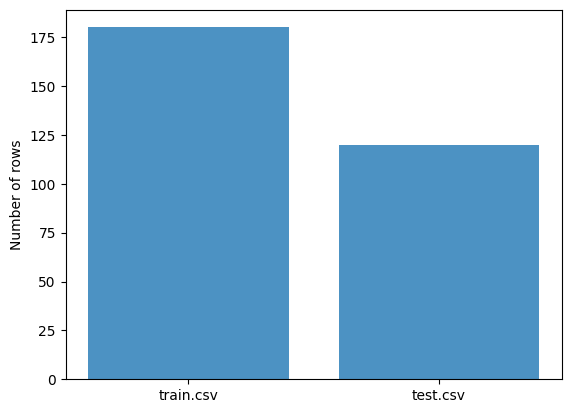

In [9]:
import matplotlib.pyplot as plt

d_names = ('train.csv', 'test.csv')
y_pos = range(len(d_names))

plt.bar(
    y_pos,
    (train.shape[0], test.shape[0]),
    align='center',
    alpha=0.8
)
plt.xticks(y_pos, d_names)
plt.ylabel('Number of rows')
plt.show()

In [10]:
print('Train rows:', train.shape[0])
print('Test rows:', test.shape[0])
print('Data columns:', test.columns.drop(['ID']).shape[0])

Train rows: 180
Test rows: 120
Data columns: 4


In [11]:
X = train[["feature1", "feature2", "feature3", "feature4"]]
y = train["target"]
X_test = test[["feature1", "feature2", "feature3", "feature4"]]
test_ids = test["ID"]


In [12]:
#ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0)) #Rifge regression model is taken with standardize the features, L2 regression is taken


In [128]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=800,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)


In [129]:
#xgboost model
xgb_reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02, #smaller more accurate training
    max_depth=6, # complexity low simple model less overfitting
    subsample=0.5,
    colsample_bytree=0.5,
    colsample_bylevel= 0.7,
    reg_lambda=5,
    reg_alpha=2,
    random_state=RANDOM_STATE,
    objective="reg:squarederror",
    tree_method="hist",
    min_child_weight=10,
    gamma=1
)

In [130]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [131]:
def cv_mse(model, name):
    mse = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error").mean()
    print(f"{name:<15} CV MSE: {mse:.5f}")
    return mse

In [132]:
#ridge_mse = cv_rmse(ridge, "Ridge")
rf_mse = cv_mse(rf, "RandomForest")
xgb_mse = cv_mse(xgb_reg, "XGBoost")

RandomForest    CV MSE: 86.86184
XGBoost         CV MSE: 89.11398


In [133]:
#ridge.fit(X, y)
rf.fit(X, y)
xgb_reg.fit(X, y)
#pred_ridge = ridge.predict(X_test)
pred_rf = rf.predict(X_test)
pred_xgb = xgb_reg.predict(X_test)

In [134]:
blend_weight = 0.2 # 20% randomforest, 80% XGB
y_pred = blend_weight * pred_rf + (1 - blend_weight) * pred_xgb


In [135]:

#train_blend = blend_weight * ridge.predict(X) + (1 - blend_weight) * xgb_reg.predict(X)
train_blend = blend_weight * rf.predict(X) + (1 - blend_weight) * xgb_reg.predict(X)

blend_mse = mean_squared_error(y, train_blend)
print(f"\nBlended model Training MSE: {blend_mse:.5f}")



Blended model Training MSE: 32.68914


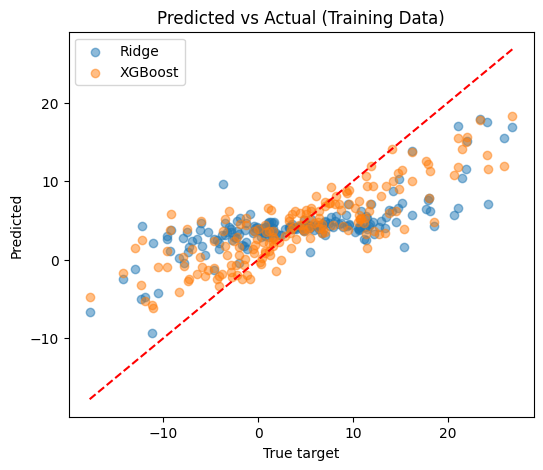

In [122]:
#=====================================================
# 8️⃣ Visualize Predicted vs Actual (Training)
# =====================================================
import matplotlib.pyplot as plt
#ridge_pred_train = ridge.predict(X)
rf_pred_train  = rf.predict(X)
xgb_pred_train   = xgb_reg.predict(X)

plt.figure(figsize=(6,5))
plt.scatter(y, rf_pred_train, alpha=0.5, label="Ridge")
plt.scatter(y, xgb_pred_train, alpha=0.5, label="XGBoost")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("True target")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs Actual (Training Data)")
plt.show()

In [127]:
y# =====================================================
submission = pd.DataFrame({"ID": test_ids, "Target": y_pred})
submission.to_csv("submission_ridge_xgb_MSE_new.csv", index=False)
print("\n✅ submission_ridge_xgb_MSE_new.csv saved successfully!")


✅ submission_ridge_xgb_MSE_new.csv saved successfully!
